# **${\Large\text{Criptografía 2024-10 - Proyecto 2}}$**

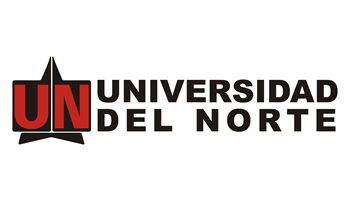

---

## **Nombre y Códigos de los Estudiantes:**
- Estudiante 1: Sonya Castro (200150166)
- Estudiante 2
- Estudiante 3
- Estudiante 4

## **Indicaciones:**

1. **El proyecto debe ser entregado a más tardar a las 11:59 p.m. del domingo 12 de mayo del 2024**, después de esto el enlace para enviar el proyecto se cerrará. Asegúrese de enviar el proyecto antes de la hora de finalización, no se aceptarán proyectos enviados por ningún otro medio.
2. El proyecto debe ser realizado en equipos de **4 integrantes**.
3. Cree una copia de este archivo de Google Colab.
4. Utilice la librería `pycryptodome` para el desarrollo del proyecto.
  - Puede instalarla ejecutando el siguiente código en una celda del archivo de Google Colab: `!pip install pycryptodome`.
5. Únicamente envíe el cuaderno de Jupyter con los códigos, las respuestas y el informe correspondiente.

## **Enunciado:**
El objetivo de este proyecto es intentar recuperar una serie de contraseñas que han sido almacenadas de manera segura utilizando 4 protocolos diferentes listados a continuación:
1. Protocolo de almacenamiento de contraseñas versión 1.
   - Se almacena `(username, H(password))`.
2. Protocolo de almacenamiento de contraseñas versión 2.
   - Se almacena `(username, salt, H(password || salt))`.
3. Protocolo de almacenamiento de contraseñas versión 3.
   - Se almacena `(username, salt, H(password || pepper || salt))`.
4. Protocolo de almacenamiento de contraseñas utilizando una PBKDF.
   - Se almacena `(username, salt, PBKDF(password, salt, 64, 2 ** 20, H))`.
     - `64` es el número de bytes que se obtentrán de la función `PBKDF`.
     - `2 ** 20` es la dificultad `d` de la función `PBKDF`.

En todos los escenarios anteriores la función hash `H` utilizada fue `SHA3_512` de `Crypto.Hash`. Para el último escenario la función PBKDF utilizada fue `PBKDF2` de `Crypto.Protocol.KDF`.

En cada escenario deberán obtener la contraseña para cada uno de los integrantes del grupo de trabajo utilizando como identificador el usuario Uninorte. Para ello, deberán utilizar el **archivo de contraseñas comunes** ([rockyou.txt](https://www.kaggle.com/datasets/wjburns/common-password-list-rockyoutxt)) provisto y la base de datos (archivo de contraseñas) correspondiente.

Se recomienda paralelizar el proceso de búsqueda de contraseñas para reducir el tiempo de ejecución.

Finalmente, se debe realizar un informe (puede ser en el mismo Jupyter Notebook / Google Colab) dónde:
1. Se expliquen los métodos / estrategias utilizados para obtener las contraseñas originales.
2. Se realice un análisis de los tiempos de ejecución de los métodos propuestos para la recuperación de las contraseñas.
3. Se realice un breve análisis de seguridad de los protocolos, contra un atacante que se robe la base de datos de las contraseñas. Adicionalmente, mencione cuál(es) protocolo(s) utilizaria usted para la protección de las contraseñas y por qué.
4. Se exponga y justifique los contratiempos y motivos en caso de no recuperar alguna de las contraseñas originales.

## Setup

In [1]:
# Librerías
%pip install pycryptodome multiprocess

import pandas as pd
import timeit
import multiprocessing
import multiprocess as mp

from time import time

from typing import List, Tuple, Dict 

from Crypto.Hash import SHA3_512
from Crypto.Protocol.KDF import PBKDF2

from os import getpid 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Lista de usernames de los integrantes del equipo 
USERNAMES = ['sonyac', 'awperez', 'mhiguita', 'cleonard'] 

In [3]:
# Función Hash (SHA3_512)

def H(data: str, salt: str = None, pepper: int = None) -> str:
  """Hash function using SHA3_512

  Args:
      data (str)
      salt (str, optional): Hex string. Defaults to None.
      pepper (int, optional): Defaults to None.

  Returns:
      str: hashed data
  """
  
  h = SHA3_512.new(data=bytes(data, "utf-8"))

  if pepper != None: 
    h.update(pepper.to_bytes(16,'big'))
  
  if salt != None: 
    h.update(bytes.fromhex(salt))

  return h.hexdigest()

In [4]:
# Decorador (timer)

def timer(f):
  def wrap(*args, **kwargs):
    t1 = time()
    result = f(*args, **kwargs)
    t2 = time()
    print(f'Function {f.__name__!r} executed in {(t2-t1):.4f}s')
    return result
  return wrap

In [5]:
# Leer plain passwords 
plain_passwords = []
with open("./data/rockyou.txt", "r", encoding="ISO-8859-1") as rockyou:
    for plain in rockyou:
        plain = plain.strip()
        plain_passwords.append(plain)
        
f"Total plain passwords = {len(plain_passwords):,}"

'Total plain passwords = 14,344,391'

In [6]:
# Analisis de tiempo previo función H
args_values = ("My amazing password that is too long", 'a81928e5f0f702f7cdcbba9ac96521c7', 2**10)

# repeat 10 times, v times through the loop
repeat, number = 10, 1

t = timeit.Timer(lambda: H(*args_values))
r = t.repeat(repeat, number) 

mean_time, best_time, worst_time = sum(r) / (repeat * number), min(r), max(r)

print(f"Mean Time: {mean_time}s")
print(f"Best Time: {best_time}s")
print(f"Worst Time: {worst_time}s")

Mean Time: 0.00013667000021087006s
Best Time: 3.170000127283856e-05s
Worst Time: 0.0008231999963754788s


## **Caso 1 (Protocolo V.1):**

### Cargar datos

In [9]:
filename = 'password_database_v1.csv'

In [10]:
# Cargar datos
db_v1 = pd.read_csv(f"data/{filename}")
db_v1 = db_v1[db_v1['username'].isin(USERNAMES)]
db_v1

,username,password
6,cleonard,b1341f3768fe16d6867037c1dc57bb5d74995f3be86259...
7,sonyac,ab0dee66b5b53241f336d588014002cd849f8fed5f847d...
26,awperez,bb23702961eaf057dc60d64de843d9b00d01d07df59789...
34,mhiguita,b457ebd7121c0865af8b7f740f8f6b147a9571981deda2...


### Ataque de diccionario

#### Descripción de la solución

Para este primer caso, vamos a precomputar el hash de un diccionario de contraseñas. Con esto, crearemos un diccionario `[hash, plain]`. 

In [12]:
# Definición de la clase 

class DicctionaryAttack:  
  def __init__(self) -> None:
    self.d: Dict[str, str] = {}
    self.generate()

  @timer
  def generate(self) -> None:
    for plain in plain_passwords:
      hash = H(plain)
      self.d[hash] = plain

  @timer
  def find(self, hash: str) -> str:
    return self.d.get(hash, None)

#### Análisis de tiempo de ejecución

Se puede estimar que el tiempo de carga puede darse por $T(H) * n$ donde $T(H)$ es el tiempo que demora la función $H$ en ejecutarse y $n$ el número de contraseñas planas conocidas. Por otro lado, el tiempo de busqueda es $O (1)$ ya que estamos haciendo una busqueda en un diccionario.

In [11]:
# Estimación de tiempo 
print(f"Tiempo estimado {mean_time * len(plain_passwords)}s")
print(f"Peor tiempo estimado {worst_time * len(plain_passwords)}s")
print(f"Mejor tiempo estimado {best_time * len(plain_passwords)}s")

Tiempo estimado 2512.850413373507s
Peor tiempo estimado 7129.162326939048s
Mejor tiempo estimado 836.2779966132148s


In [13]:
# Cargar el diccionario 
# Tiempo estimado = 7.5 min 
attack = DicctionaryAttack()

KeyboardInterrupt: 

#### Prueba: 'pollito'

Pollito esta entre los primeras posiciones del arreglo `plan_password` (974) por lo que debería ejecutarse en poco tiempo. Realizamos esta prueba para comprobar que el código si encuentre las contraseñas de forma correcta.

In [27]:
# Pre-test: pollito
assert(attack.find(H("pollito")) == 'pollito'), f"Test failed. Expected pollito."

Function 'find' executed in 0.0000s


#### Resultados

Ahora que se ha verificado la validez de la solución, probaremos buscando las contraseñas para nuestros usuarios. 

In [20]:
# Solución
for index, row in db_v1.iterrows():
    hash_pwd = row["password"]
    pwd = attack.find(hash_pwd)

    print(row["username"], pwd, "\n")
    assert(hash_pwd == H(pwd)), f"Test failed. Expected {hash_pwd}, got {H(pwd)}."    

Function 'find' executed in 0.0000s
cleonard 0923612667jfb 

Function 'find' executed in 0.0000s
sonyac shmily69 

Function 'find' executed in 0.0000s
awperez 19no583 

Function 'find' executed in 0.0000s
mhiguita camycarmen 



### Análisis de seguridad

## **Caso 2 (Protocolo V.2):**

### Cargar datos

In [43]:
filename = 'password_database_v2.csv'

In [48]:
# Cargar datos
db_v2 = pd.read_csv(f"data/{filename}")
db_v2 = db_v2[db_v2['username'].isin(USERNAMES)]
db_v2

,username,salt,password
6,cleonard,a81928e5f0f702f7cdcbba9ac96521c7,5c01545c628590a2d2072d314f5c3eef5d52afd40141f9...
7,sonyac,9561a9e469aaa3c065108e1dfeff0013,4608e8818ef3c4e30c04dc48b0c5ae8275bbad82bdd8b0...
26,awperez,a57380d3093d9a596a08b5fdee1cf414,5e5a576eb2c6d109ac0dd4cdde6e803238ae5e6159f5e0...
34,mhiguita,9ffd77ed58231bfabfdc0ceafe8b47c3,0e7cd1aea3597bde370e3fa47873480993a960bd1c98ea...


### Ataque Diccionario con Sal

#### Descripción de la solución

Para este ataque no podemos ni tiene mucho sentido precomputar todos los datos. Por ello, debemos recorre la lista de `plain_passwords` junto con la salt hasta encontrar la contaseña. 

In [46]:
# Definición de la clase 
class AttackWithSalt:
  @timer 
  def find(hash, salt):
    for pwd in plain_passwords:
      if H(pwd, salt) == hash: 
        return pwd

#### Análisis de tiempos de ejecución

En el mejor de los casos, la contraseña será el primero elemento de `plain_passwords`, y en el peor de los casos sería el último. La búsqueda de contraseñas tiene complejidad $O(n)$ donde $n$ es el número de contraseñas en texto plano conocidas.  

In [ ]:
# Estimación de tiempo
print(f"Peor tiempo estimado {mean_time * len(plain_passwords)}s")
print(f"Peor-peor tiempo estimado {worst_time * len(plain_passwords)}s")
print(f"Mejor-Peor tiempo estimado {best_time * len(plain_passwords)}s")

Tiempo estimado 1029.2100582561065s
Peor tiempo estimado 4554.3441709552135s
Mejor tiempo estimado 370.08528784408554s


#### Prueba: 'pollito'

Como conocemos la posición en la lista de 'pollito', y hemos calculado el promedio, mejor y peor tiempo de ejecución para la función $H$, podemos estimar el tiempo que tomará encontrar a 'pollito'.

In [54]:
# Pre-test
print(f"Tiempo estimado para encontrar pollito = {plain_passwords.index('pollito') * mean_time}s")
print(f"Mejor tiempo estimado para encontrar pollito = {plain_passwords.index('pollito') * best_time}s")
print(f"Peor tiempo estimado para encontrar pollito = {plain_passwords.index('pollito') * worst_time}s")

_, salt, _ = db_v2.iloc[1]
result = AttackWithSalt.find(H('pollito', salt), salt)
assert(result == 'pollito')

Tiempo estimado para encontrar pollito = 0.06988450027201906s
Mejor tiempo estimado para encontrar pollito = 0.025129200002993457s
Peor tiempo estimado para encontrar pollito = 0.30924500193214044s
Function 'find' executed in 0.0125s


#### Resultados

Ya que hemos comprobado la validez de la solución, vamos a encontrar las contraseñas para nuestros usuarios

In [20]:
# Resultados 
for index, row in db_v2.iterrows():
    username, salt, hash_pwd = row

    pwd = AttackWithSalt.find(hash_pwd, salt)
    print(username, pwd, "\n")
    
    assert(hash_pwd == H(pwd, salt)), f"Test failed. Expected {hash_pwd}, got {H(pwd)}."    

Function 'find' executed in 202.1261s
cleonard bklyn21 

Function 'find' executed in 180.3625s
sonyac delancruz 

Function 'find' executed in 2.2733s
awperez daisy69 

Function 'find' executed in 84.7931s
mhiguita sabcar1691 



### Análisis de seguridad

## **Caso 3 (Protocolo V.3):**

### Cargar datos

In [13]:
filename = 'password_database_v3.csv'

In [14]:
# Cargar datos
db_v3 = pd.read_csv(f"data/{filename}")
db_v3 = db_v3[db_v3['username'].isin(USERNAMES)]
db_v3

,username,salt,password
6,cleonard,6f4d6d33c87c1d9b21d1d83266c58315,11914ea389eea189a08dcc5dcd57aa7d83147b2cb2df45...
7,sonyac,b3c1fd8f9273f2ac67a129264c0b0d41,94e6fdd645b356a46eb3605618921a3010efd617995b87...
26,awperez,09fa1e94b3d5301da3c5a79ce0846873,7298f05d293472f8afcebe97327ab4ee246f623131cfbe...
34,mhiguita,e56e773ca407cc7f2055f20a4f00279f,dff30c9988e97f003cb855204cb0871d0ff62e965f1cda...


### Ataque dicionaro con sal y pimienta

**Análisis de tiempos de ejecución**

Para el ataque con sal y pimienta, tenemos que hacer una solución similar al ataque con sal, solo que, **además**, debemos probar con las $2^{16}$ primientas posibles. Esto general una complejidad de $O(n \times 2^{16})$, donde $n$ es el número de contraseñas en texto plano conocidas. De igual forma, el mejor tiempo sería si la contraseña es el primer elemento de la fila, y el peor tiempo si es el último. Ya que el tiempo es muy grande, consideramos que es mejor expresarlo en años (no bisiestos).

In [11]:
# Total número de combinaciones
combinations = len(plain_passwords) * (2**16)
print(f"Total combinations {combinations:,}")

# Estimación de tiempo
print(f"Peor tiempo estimado {mean_time * combinations / (60 * 60 * 24 * 365)} años")
print(f"Peor-peor tiempo estimado {worst_time * combinations / (60 * 60 * 24 * 365)} años")
print(f"Mejor-peor tiempo estimado {best_time * combinations / (60 * 60 * 24 * 365)} años")

Peor tiempo estimado 3.397734066060529 años
Peor-peor tiempo estimado 22.794618454904807 años
Mejor-peor tiempo estimado 0.9459975553555069 años


In [12]:
# Definición de la clase 
class AttackWithSaltAndPepper:
  @timer
  @staticmethod
  def find(plain_passwords, hash, salt):
    for pwd in plain_passwords:
      for pepper in range(2**16):
        if H(pwd, salt, pepper) == hash: 
          return pwd

**Prueba pollito**

Aunque no tenemos muchas esperanzas en esta solución, quisimos probar cuanto tiempo demora en ejecutar la prueba pollito que es una de las más 'sencillas' de encontrar.

In [ ]:
# Prueba pollito 
print(f"Tiempo estimado para encontrar pollito = {plain_passwords.index('pollito') * (2**16) * mean_time}s")
print(f"Mejor tiempo estimado para encontrar pollito = {plain_passwords.index('pollito') * (2**16) * best_time}s")
print(f"Peor tiempo estimado para encontrar pollito = {plain_passwords.index('pollito') * (2**16) * worst_time}s")

_, salt, _ = db_v3.iloc[1]
result = AttackWithSaltAndPepper.find(plain_passwords, H('pollito', salt, 123), salt)
assert(result == 'pollito')

```
Tiempo estimado para encontrar pollito = 4579.950609827041s
Mejor tiempo estimado para encontrar pollito = 1646.8672513961792s
Peor tiempo estimado para encontrar pollito = 20266.680446624756s
Function 'find' executed in 1334.9037s
```

### Ataque paralelo

#### Descripción de la solución

Debido a problemas con la ejecución de multiprocesso en python, escribimos la solución como un script aparte.

In [27]:
%%writefile ./scripts/parallel.py

import sys
from os import getpid 
import multiprocessing as mp

from time import time
from Crypto.Hash import SHA3_512

global plain_passwords
plain_passwords = []

# Leer contraseñas en texto plano
with open("./data/rockyou.txt", "r", encoding="ISO-8859-1") as rockyou:
  for plain in rockyou:
    plain = plain.strip()
    plain_passwords.append(plain)

def H(data: str, salt: str = None, pepper: int = None) -> str:
  """Hash function using SHA3_512

  Args:
      data (str)
      salt (str, optional): Hex string. Defaults to None.
      pepper (int, optional): Defaults to None.

  Returns:
      str: hashed data
  """
  
  h = SHA3_512.new(data=bytes(data, "utf-8"))

  if pepper != None: 
    h.update(pepper.to_bytes(16,'big'))
  
  if salt != None: 
    h.update(bytes.fromhex(salt))

  return h.hexdigest()


# Decorador para el calculo de tiempo
def timer(f):
  def wrap(*args, **kwargs):
    t1 = time()
    result = f(*args, **kwargs)
    t2 = time()
    print(f'Function {f.__name__!r} executed in {(t2-t1):.4f}s')
    return result
  return wrap


# Definición de la clase
class ParallelAtack:

  @staticmethod
  def _worker(
    processs_id: int,
    hash: str,
    salt: str,
    found_event: mp.Event) -> None:
    
    print(f"Start process {processs_id} {[{getpid()}]}\n", flush=True)

    chunk_size = len(plain_passwords) // mp.cpu_count()
    start_index = processs_id * chunk_size
    end_index = (processs_id + 1) * chunk_size if processs_id < mp.cpu_count() - 1 else len(plain_passwords)
    
    # print(f"Process {processs_id} {[{getpid()}]} | plan passwords head = {plain_passwords[start_index:start_index +10]}\n", flush=True)
    
    for pwd in plain_passwords[start_index:end_index]:
      # if processs_id == 3: print(pwd, flush=True)
      
      for pepper in range(2**16):
        if H(pwd, salt, pepper) == hash:
          print(f"Finishing process {processs_id} {[{getpid()}]} | Found {pwd} \n", flush=True)
          found_event.set()
          return pwd 
            
    print(f"Finishing process {processs_id} {[{getpid()}]} | not found \n", flush=True)

  @timer
  @staticmethod
  def find(
    hash: str,
    salt: str) -> None:

    num_processes = mp.cpu_count()

    print(f"num of process = {num_processes}")

    found_event = mp.Event()

    pool = [
      mp.Process(
        target=ParallelAtack._worker,
        args=(i, hash, salt, found_event)
      )
      for i in range(num_processes)
    ]

    print("Starting process")
    for p in pool: p.start()
    
    # block until condition met
    found_event.wait()

    print("Terminate")
    for p in pool: p.terminate()

    print("Join process")
    for p in pool: p.join()


if __name__ == "__main__":
	print(f"Total passwords = {len(plain_passwords)}")
  
	password, salt = sys.argv[1:]

	print(password, salt)
	
	mp.set_start_method('spawn')  # Set start method to 'spawn'
	ParallelAtack.find(password, salt)

Overwriting ./scripts/parallel.py


#### Análisis de tiempos de ejecución

Para el ataque paralelo, vamos a dividir el arreglo de plain passwords en "pedacitos". Para este caso, la complejidad estaría dada por $O(\frac{n \times 2^{16}}{m})$ donde $n$ es el número de contraseñas planas conocidas y $m$ es el número de process que se pueden crear. En nuestro caso, estaremos usando m como el número de cpus en el sistema. Ya que el tiempo es muy grande, consideramos que es mejor expresarlo en años (no bisiestos).

In [9]:
# Estimación de tiempo 
cpu_count = mp.cpu_count()
print(f"cpu count = {cpu_count}")

print(f"Peor tiempo estimado {mean_time * len(plain_passwords) * (2**16) / cpu_count / (60 * 60 * 24 * 365)}años")
print(f"Peor-peor tiempo estimado {worst_time * len(plain_passwords) * (2**16) / cpu_count / (60 * 60 * 24 * 365)}años")
print(f"Mejor-peor tiempo estimado {best_time * len(plain_passwords) * (2**16) / cpu_count / (60 * 60 * 24 * 365)}años")

cpu count = 8
Peor tiempo estimado 0.6038297217838414años
Peor-peor tiempo estimado 1.4848882665476737años
Mejor-peor tiempo estimado 0.2910157437501201años


Podemos notar una gran mejoría respecto al la solución anterior, aun así el tiempo de ejecución es grande.

#### Prueba: 'morelove3'

Ya que 'pollito' probablemente esta en el primer *chunk*, probaremos con la contraseña 'morelove3', que es de las primeras del tercer *chunk*.

Comando ejecutado:

```
python scripts/parallel.py '0813d32aa92333cfdc66db03a0df2609c2d65b8745608d888c6d74b4a2035ef0b11106aa3fd6da6f1ee7c6f729c66a238d98c12122f809d716d204d324e022f6' 'b3c1fd8f9273f2ac67a129264c0b0d41' > logs/morelove3.txt
```

Resultados:
```
Start process 2 [{23412}]

Start process 0 [{11404}]

Start process 7 [{23504}]

Start process 5 [{19460}]

Start process 1 [{4932}]

Start process 4 [{15112}]

Start process 6 [{24472}]

Start process 3 [{22740}]

Finishing process 3 [{22740}] | Found morelove3 

Total passwords = 14344391
0813d32aa92333cfdc66db03a0df2609c2d65b8745608d888c6d74b4a2035ef0b11106aa3fd6da6f1ee7c6f729c66a238d98c12122f809d716d204d324e022f6 b3c1fd8f9273f2ac67a129264c0b0d41
num of process = 8
Starting process
Terminate
Join process
Function 'find' executed in 28.2054s
```

In [13]:
# Encontrar un chunk para el process 3
chunk_size = len(plain_passwords) // mp.cpu_count()
plain_passwords[chunk_size*3:chunk_size*3+10]

['morelox2',
 'morelowend',
 'moreloveok',
 'morelove7',
 'morelove4',
 'morelove3',
 'morelove23',
 'morelove2',
 'morelotes',
 'morelost87']

In [20]:
# Generar un hash y la sal para la prueba
_, salt, _ = db_v3.iloc[1]
H('morelove3', salt, 123), salt

('0813d32aa92333cfdc66db03a0df2609c2d65b8745608d888c6d74b4a2035ef0b11106aa3fd6da6f1ee7c6f729c66a238d98c12122f809d716d204d324e022f6',
 'b3c1fd8f9273f2ac67a129264c0b0d41')

### Ataque 'cluster'

#### Descripción de la solución

In [32]:
%%writefile ./scripts/cluster.py

import sys
import multiprocessing
from os import getpid 

from time import time
from Crypto.Hash import SHA3_512


def H(data: str, salt: str = None, pepper: int = None) -> str:
  """Hash function using SHA3_512

  Args:
      data (str)
      salt (str, optional): Hex string. Defaults to None.
      pepper (int, optional): Defaults to None.

  Returns:
      str: hashed data
  """
  
  h = SHA3_512.new(data=bytes(data, "utf-8"))

  if pepper != None: 
    h.update(pepper.to_bytes(16,'big'))
  
  if salt != None: 
    h.update(bytes.fromhex(salt))

  return h.hexdigest()


def timer(f):
  def wrap(*args, **kwargs):
    t1 = time()
    result = f(*args, **kwargs)
    t2 = time()
    print(f'Function {f.__name__!r} executed in {(t2-t1):.4f}s')
    return result
  return wrap


# Definición de la clase
class ParallelAtack:

  @staticmethod
  def _worker(
    process_id: str,
    plain_passwords,
    hash: str,
    salt: str,
    found_event: multiprocessing.Event) -> None:
    
    print(f"Start process {process_id} {[{getpid()}]}\n", flush=True)

    chunk_size = len(plain_passwords) // multiprocessing.cpu_count()
    start_index = process_id * chunk_size
    end_index = (process_id + 1) * chunk_size if process_id < multiprocessing.cpu_count() - 1 else len(plain_passwords)
    
    for pwd in plain_passwords[start_index:end_index]:
      
      for pepper in range(2**16):
        if H(pwd, salt, pepper) == hash:
          print(f"Finishing process {process_id} {[{getpid()}]} | Found {pwd} \n", flush=True)
          found_event.set()
          return pwd 
            
    print(f"Finishing process {process_id} {[{getpid()}]} | not found \n", flush=True)

  @timer
  @staticmethod
  def find(
    plain_passwords,
    hash: str,
    salt: str) -> None:

    num_processes = multiprocessing.cpu_count()

    print(f"num of process = {num_processes}")

    found_event = multiprocessing.Event()

    pool = [
      multiprocessing.Process(
        target=ParallelAtack._worker,
        args=(i, plain_passwords,hash, salt, found_event)
      )
      for i in range(num_processes)
    ]

    print("Starting process")
    for p in pool: p.start()
    
    # block until condition met
    found_event.wait()

    print("Terminate")
    for p in pool: p.terminate()

    print("Join process")
    for p in pool: p.join()


if __name__ == "__main__":

  plain_passwords = []

  cluster_id, cluster_size, password, salt = sys.argv[1:]

  cluster_id = int(cluster_id)
  cluster_size = int(cluster_size)

  with open("./data/rockyou.txt", "r", encoding="ISO-8859-1") as rockyou:
    for plain in rockyou:
      plain = plain.strip()
      plain_passwords.append(plain)

  chunk_size = len(plain_passwords) // cluster_size
  start_index = cluster_id * chunk_size
  end_index = (cluster_id + 1) * chunk_size if cluster_id < cluster_size - 1 else len(plain_passwords)

  plain_passwords = plain_passwords[start_index:end_index]
  print(f"Total passwords = {len(plain_passwords)}")

  ParallelAtack.find(plain_passwords, password, salt)

Overwriting ./scripts/cluster.py


#### Análisis de tiempos de ejecución

$$
O(\cfrac{n \times 2^{16}}{m_0 + ... + m_c })
$$

Donde $n$ es el número de contraseñas en texto plano conocidas, $m_i$ el número de processos que se pueden crear para el computador $i$ y $c$ es el tamaño del cluster (número de conmputadores). En nuestro caso 

- $m_0 \rightarrow cleonard$
- $m_1 \rightarrow sonyac$
- $m_2 \rightarrow awperez$
- $m_3 \rightarrow mhiguita$

In [15]:
# Estimación de tiempo 
m = [8, 8, 8, 8]

print(f"Peor tiempo estimado {mean_time * len(plain_passwords) * (2**16) / sum(m) / (60 * 60 * 24)} días")
print(f"Peor-peor tiempo estimado {worst_time * len(plain_passwords) * (2**16) / sum(m) / (60 * 60 * 24)} días")
print(f"Mejor-peor tiempo estimado {best_time * len(plain_passwords) * (2**16) / sum(m) / (60 * 60 * 24)} días")

Peor tiempo estimado 46.46987664580273 días
Peor-peor tiempo estimado 279.9005065293855 días
Mejor-peor tiempo estimado 10.7784820849326 días


#### Prueba 'corapucino'

Similar a prubebas anteriores, hemos buscado un caso sencillo para el cluster 2, process 4



Comando ejecutado:
```
python scripts/cluster.py 2 4 '08bd751a02c27eb0927d07b5416fb7c8109ea8cd3fd389a97caf09112938677ca5a166a8f9f8d26bc5fb87007b1b0b9910e57af97bfd7fd3d7e33887435eb953' 'b3c1fd8f9273f2ac67a129264c0b0d41' > logs/corapucino.txt
```

Resultados: 

```
Start process 0 [{6160}]

Start process 1 [{19132}]

Start process 2 [{5456}]

Start process 3 [{10592}]

Start process 4 [{21420}]

Start process 5 [{21512}]

Start process 6 [{21124}]

Start process 7 [{19928}]

Finishing process 4 [{21420}] | Found corapucino 

Total passwords = 3586097
num of process = 8
Starting process
Terminate
Join process
Function 'find' executed in 36.2919s
```

In [31]:
# Calcular el framento para el clsuter 2
cluster_id = 2
cluster_size = 4

chunk_size = len(plain_passwords) // cluster_size
start_index = cluster_id * chunk_size
end_index = (cluster_id + 1) * chunk_size if cluster_id < cluster_size - 1 else len(plain_passwords)

cluster_plain_passwords = plain_passwords[start_index:end_index]
print(cluster_plain_passwords[:5])

# Calcular el chunk para el process 4
process_id = 4
# Obtener uno de los primeros

chunk_size = len(cluster_plain_passwords) // multiprocessing.cpu_count()
start_index = process_id * chunk_size
cluster_plain_passwords[start_index:start_index + 10]

['janeimeelyzza', 'janeily', 'janeilweir', 'janeilsnephew', 'janeilpinder']


['corarteaga',
 'corarox',
 'corarose3',
 'corarose1',
 'corarodgers',
 'coraroaw',
 'coraralston',
 'corara',
 'coraqzon14',
 'corapucino']

In [22]:
# Generar un hash y la sal para la prueba
_, salt, _ = db_v3.iloc[1]
H('corapucino', salt, 123), salt

('08bd751a02c27eb0927d07b5416fb7c8109ea8cd3fd389a97caf09112938677ca5a166a8f9f8d26bc5fb87007b1b0b9910e57af97bfd7fd3d7e33887435eb953',
 'b3c1fd8f9273f2ac67a129264c0b0d41')

#### Resultados

**Para cleonard**

In [38]:
db_v3

,username,salt,password
6,cleonard,6f4d6d33c87c1d9b21d1d83266c58315,11914ea389eea189a08dcc5dcd57aa7d83147b2cb2df45...
7,sonyac,b3c1fd8f9273f2ac67a129264c0b0d41,94e6fdd645b356a46eb3605618921a3010efd617995b87...
26,awperez,09fa1e94b3d5301da3c5a79ce0846873,7298f05d293472f8afcebe97327ab4ee246f623131cfbe...
34,mhiguita,e56e773ca407cc7f2055f20a4f00279f,dff30c9988e97f003cb855204cb0871d0ff62e965f1cda...


In [39]:
username, salt, password = db_v3.iloc[0]

print("salt",salt)
print("password",password)

salt 6f4d6d33c87c1d9b21d1d83266c58315
password 11914ea389eea189a08dcc5dcd57aa7d83147b2cb2df45857c0ca2dd6d967d06c6e03b384c4da802c2dff9d8c0817c8ddacd1351deea323f845c6cb010fa8ff3


| PC         | cluster id | output file                 |
|------------|------------|-----------------------------|
| 0-cleonard | 0          | `logs/caso3_cleonard_01.txt`|
| 1-sonyac   | 1          | `logs/caso3_cleonard_02.txt`|
| 2-awperez  | 2          | `logs/caso3_cleonard_03.txt`|
| 3-mhiguita | 3          | `logs/caso3_cleonard_04.txt`|

```
python scripts/cluster.py [cluster id] 4 '11914ea389eea189a08dcc5dcd57aa7d83147b2cb2df45857c0ca2dd6d967d06c6e03b384c4da802c2dff9d8c0817c8ddacd1351deea323f845c6cb010fa8ff3' '6f4d6d33c87c1d9b21d1d83266c58315' > [output file]
```

## **Caso 4 (Protocolo V.PBKDF):**

In [23]:
filename = 'password_database_vPBKDF.csv'

**Análisis de tiempos de ejecución**

Para el ataque con sal y la función PBKDF, tenemos que hacer una solución similar al ataque con sal y pimienta, solo que, **no hay pimienta**, sino que debemos probar con las $2^{20}$ veces que se deriva la salt original para obtener salts derivadas en base a la dificultad de la funcion PBKDF. Esto genera una complejidad de $O(n \times 2^{20})$, donde $n$ es el número de contraseñas en texto plano conocidas. De igual forma, el mejor tiempo sería si la contraseña es el primer elemento de la fila, y el peor tiempo si es el último. Ya que el tiempo es muy grande, consideramos que es mejor expresarlo en años (no bisiestos).

In [3]:
# Total número de combinaciones
combinations = len(plain_passwords) * (2**20)
print(f"Total combinations {combinations:,}")

# Estimación de tiempo
print(f"Peor tiempo estimado {mean_time * combinations / (60 * 60 * 24 * 365)} años")
print(f"Peor-peor tiempo estimado {worst_time * combinations / (60 * 60 * 24 * 365)} años")
print(f"Mejor-peor tiempo estimado {best_time * combinations / (60 * 60 * 24 * 365)} años")

Total combinations 15,041,184,137,216


NameError: name 'mean_time' is not defined

In [24]:
db_v4 = pd.read_csv(f"password_databases/{filename}")
db_v4 = db_v4[db_v4['username'].isin(USERNAMES)]
db_v4

,username,salt,password
6,cleonard,8fed37998d510c9c9592838a95c1e877,dad1b4da1217134f75ee8d0474055744d3af164c4a1e53...
7,sonyac,d961c66b3ba34c68613c58a21246ce1c,91dfd17c46ea70cc5e44e634742dbb136fc88c1a520555...
26,awperez,1aae169aa671518a6dad79bbb8c6211e,5b5ad377d1fb4fff48d9c3a9c9515e0735dcd5a746ad2d...
34,mhiguita,f6a805e824d392bd0eb7dfea2133bc28,0488044185453426d4e3260ed4f4341affd1196c7973b8...


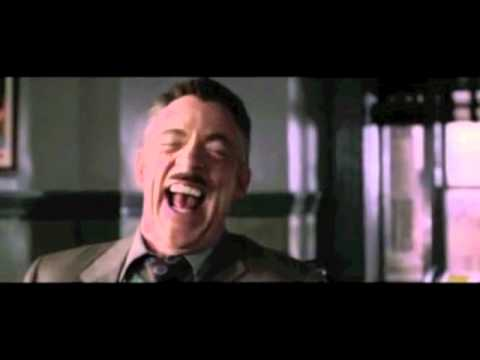

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo('ztVMib1T4T4', width=800, height=300)

## **Conclusión**

Se exponga y justifique los contratiempos y motivos en caso de no recuperar alguna de las contraseñas originales